In [1]:
%matplotlib inline
import glob
import numpy as np
import numba as nb
import cv2
from skimage.feature import peak_local_max
from scipy.spatial import cKDTree as KDTree
import skimage
import matplotlib.pyplot as plt

In [2]:
@nb.njit
def cylindrical_projection(x, f):
    canvas = np.zeros_like(x)
    h, w = x.shape[:2]
    cx, cy = w//2, h//2
    for i in range(h):
        for j in range(w):
            ci = i-cy
            cj = j-cx
            ii = int(np.round(f*ci/np.sqrt(cj**2 + f**2) + cy))
            jj = int(np.round(f*np.arctan2(cj,f) + cx))
            if 0 <= ii < h and 0 <= jj < w:
                canvas[ii, jj] = x[i, j]
    return canvas

In [3]:
import numpy as np
import math
import time

class SIFTDescriptor(object):
    """Class for computing SIFT descriptor of the square patch

    Attributes:
        patchSize: size of the patch in pixels 
        maxBinValue: maximum descriptor element after L2 normalization. All above are clipped to this value
        numOrientationBins: number of orientation bins for histogram
        numSpatialBins: number of spatial bins. The final descriptor size is numSpatialBins x numSpatialBins x numOrientationBins
    """
    def precomputebins(self):
        halfSize = int(self.patchSize/2)
        ps = self.patchSize
        sb = self.spatialBins;
        step = float(self.spatialBins + 1) / (2 * halfSize)
        precomp_bins = np.zeros(2*ps, dtype = np.int32)
        precomp_weights = np.zeros(2*ps, dtype = np.float)
        precomp_bin_weights_by_bx_py_px_mapping = np.zeros((sb,sb,ps,ps), dtype = np.float)
        for i in range(ps):
            i1 = i + ps
            x = step * i
            xi = int(x)
            # bin indices
            precomp_bins[i] = xi -1;
            precomp_bins[i1] = xi
            #bin weights
            precomp_weights[i1] = x - xi;
            precomp_weights[i] = 1.0 - precomp_weights[i1];
            #truncate 
            if  (precomp_bins[i] < 0):
                precomp_bins[i] = 0;
                precomp_weights[i] = 0
            if  (precomp_bins[i] >= self.spatialBins):
                precomp_bins[i] = self.spatialBins - 1;
                precomp_weights[i] = 0
            if  (precomp_bins[i1] < 0):
                precomp_bins[i1] = 0;
                precomp_weights[i1] = 0
            if  (precomp_bins[i1] >= self.spatialBins):
                precomp_bins[i1] = self.spatialBins - 1;
                precomp_weights[i1] = 0
        for y in range(ps):
            for x in range(ps):
                precomp_bin_weights_by_bx_py_px_mapping[precomp_bins[y], precomp_bins[x], y, x ] += precomp_weights[y]*precomp_weights[x]
                precomp_bin_weights_by_bx_py_px_mapping[precomp_bins[y+ps], precomp_bins[x], y, x ] += precomp_weights[y+ps]*precomp_weights[x]
                precomp_bin_weights_by_bx_py_px_mapping[precomp_bins[y], precomp_bins[x+ps], y, x ] += precomp_weights[y]*precomp_weights[x+ps]
                precomp_bin_weights_by_bx_py_px_mapping[precomp_bins[y+ps], precomp_bins[x+ps], y, x ] += precomp_weights[y+ps]*precomp_weights[x+ps]
        if self.mask_type == 'CircularGauss':
            mask = self.CircularGaussKernel(kernlen=self.patchSize, circ=True, sigma_type=self.sigma_type).astype(np.float32)
        elif self.mask_type == 'Gauss':
            mask = self.CircularGaussKernel(kernlen=self.patchSize, circ=False, sigma_type=self.sigma_type).astype(np.float32)
        else:
            raise ValueError(masktype, 'is unknown mask type')

        for y in range(sb):
            for x in range(sb):
                precomp_bin_weights_by_bx_py_px_mapping[y,x,:,:] *= mask
                precomp_bin_weights_by_bx_py_px_mapping[y,x,:,:] = np.maximum(0,precomp_bin_weights_by_bx_py_px_mapping[y,x,:,:])
        return precomp_bins.astype(np.int32),precomp_weights,precomp_bin_weights_by_bx_py_px_mapping,mask
    def __repr__(self):
            return self.__class__.__name__ + '(' + 'orientationBins=' + str(self.orientationBins) +\
             ', ' + 'spatialBins=' + str(self.spatialBins) +\
             ', ' + 'patchSize=' + str(self.patchSize) +\
             ', ' + 'sigma_type=' + str(self.sigma_type) +\
             ', ' + 'mask_type=' + str(self.mask_type) +\
             ', ' + 'maxBinValue=' + str(self.maxBinValue) + ')'

    def __init__(self, patchSize = 41,
                 maxBinValue = 0.2,
                 numOrientationBins = 8,
                 numSpatialBins = 4,
                 mask_type = 'CircularGauss',
                 sigma_type = 'hesamp'):
        self.patchSize = patchSize
        self.maxBinValue = maxBinValue
        self.orientationBins = numOrientationBins
        self.spatialBins = numSpatialBins
        self.mask_type = mask_type
        self.sigma_type = sigma_type
        self.precomp_bins,self.precomp_weights,self.mapping,self.mask = self.precomputebins()
        self.binaryMask = self.mask > 0
        self.gx = np.zeros((patchSize,patchSize), dtype=np.float)
        self.gy = np.zeros((patchSize,patchSize), dtype=np.float)
        self.ori = np.zeros((patchSize,patchSize), dtype=np.float)
        self.mag = np.zeros((patchSize,patchSize), dtype=np.float)
        self.norm_patch = np.zeros((patchSize,patchSize), dtype=np.float)
        ps = self.patchSize
        sb = self.spatialBins
        ob = self.orientationBins
        self.desc = np.zeros((ob, sb , sb ), dtype = np.float)
        return
    def CircularGaussKernel(self,kernlen=21, circ = True, sigma_type = 'hesamp'):
        halfSize = float(kernlen) / 2.;
        r2 = float(halfSize**2);
        if sigma_type == 'hesamp':
            sigma_mul_2 = 0.9 * r2;
        elif sigma_type == 'vlfeat':
            sigma_mul_2 = kernlen**2
        else:
            raise ValueError('Unknown sigma_type', sigma_type, 'try hesamp or vlfeat')
        disq = 0;
        kernel = np.zeros((kernlen,kernlen))
        for y in range(kernlen):
            for x in range(kernlen):
                disq = (y - halfSize+0.5)**2 +  (x - halfSize+0.5)**2;
                kernel[y,x] = math.exp(-disq / sigma_mul_2)
                if circ and (disq >= r2):
                    kernel[y,x] = 0.
        return kernel
    def photonorm(self, patch, binaryMask = None):
        if binaryMask is not None:
            std1_coef = 50. /  max(np.std(patch[binaryMask]), 1e-8)
            mean1 =  np.mean(patch[binaryMask])
        else:
            std1_coef = 50. / max(np.std(patch), 1e-8)
            mean1 =  np.mean(patch)
        if std1_coef >= 50. / 0.000001:
            std1_coef = 50.0
        self.norm_patch = 128. + std1_coef * (patch - mean1);
        self.norm_patch = np.clip(self.norm_patch, 0.,255.);
        return
    def getDerivatives(self,image):
        #[-1 1] kernel for borders
        self.gx[:,0] = image[:,1] - image[:,0]
        self.gy[0,:] = image[1,:] - image[0,:]
        self.gx[:,-1] = image[:,-1] - image[:,-2]
        self.gy[-1,:] = image[-1,:] - image[-2,:]
        #[-1 0 1] kernel for the rest
        self.gy[1:-2,:] = image[2:-1,:] - image[0:-3,:]
        self.gx[:,1:-2] = image[:,2:-1] - image[:,0:-3]
        self.gx *= 0.5
        self.gy *= 0.5
        return
    def samplePatch(self,grad,ori):
        ps = self.patchSize
        sb = self.spatialBins
        ob = self.orientationBins
        o_big = float(ob) * (ori + 2.0*math.pi) / (2.0 * math.pi)
        bo0_big = np.floor(o_big)#.astype(np.int32)
        wo1_big = o_big - bo0_big;
        bo0_big = bo0_big % ob;
        bo1_big = (bo0_big + 1.0) % ob;
        wo0_big = 1.0 - wo1_big;
        wo0_big *= grad;
        wo0_big = np.maximum(0, wo0_big)
        wo1_big *= grad;
        wo1_big = np.maximum(0, wo1_big)
        ori_weight_map = np.zeros((ob,ps,ps))
        for o in range(ob):
            relevant0 = np.where(bo0_big == o)
            ori_weight_map[o, relevant0[0], relevant0[1]] = wo0_big[relevant0[0], relevant0[1]]
            relevant1 = np.where(bo1_big == o)
            ori_weight_map[o, relevant1[0], relevant1[1]] += wo1_big[relevant1[0], relevant1[1]]
        for y in range(sb):
            for x in range(sb):
                self.desc[:,y,x] =  np.tensordot( ori_weight_map, self.mapping[y,x,:,:])
        return
    def describe(self,patch, userootsift = False, flatten = True, show_timings = False):
        t = time.time()
        self.photonorm(patch, binaryMask = self.binaryMask);
        if show_timings:
            print( 'photonorm time = ', time.time() - t)
            t = time.time()
        self.getDerivatives(self.norm_patch)
        if show_timings:
            print( 'gradients time = ', time.time() - t)
            t = time.time()
        self.mag = np.sqrt(self.gx * self.gx + self.gy*self.gy)
        self.ori = np.arctan2(self.gy,self.gx)
        if show_timings:
            print( 'mag + ori time = ', time.time() - t)
            t = time.time()
        self.samplePatch(self.mag,self.ori)
        if show_timings:
            print( 'sample patch time = ', time.time() - t)
            t = time.time()
        self.desc /= np.clip(np.linalg.norm(self.desc.flatten(),2), 1e-8, np.inf)
        self.desc = np.clip(self.desc, 0,self.maxBinValue)
        self.desc /= np.clip(np.linalg.norm(self.desc.flatten(),2), 1e-8, np.inf)
        if userootsift:
            self.desc = np.sqrt(self.desc / np.clip(np.linalg.norm(unnorm_desc.flatten(),1), 1e-8, np.inf))
        if show_timings:
            print( 'clip and norm time = ', time.time() - t)
            t = time.time()
        if flatten:
            return np.clip(512. * self.desc.flatten() , 0, 255).astype(np.int32);
        else:
            return np.clip(512. * self.desc , 0, 255).astype(np.int32);

In [4]:
def harris_response(img, window_size=(3,3), k=0.04):
    h, w = img.shape[:2]
    gray = img if len(img.shape)==2 else cv2.cvtColor(img.astype(np.float64), cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.float64)
    Ix = cv2.Sobel(gray,cv2.CV_64F,1,0)
    Iy = cv2.Sobel(gray,cv2.CV_64F,0,1)
    Ixx = Ix*Ix
    Iyy = Iy*Iy
    Ixy = Ix*Iy
    gIxx = cv2.GaussianBlur(Ixx,window_size,0) # (H, W)
    gIyy = cv2.GaussianBlur(Iyy,window_size,0) # (H, W)
    gIxy = cv2.GaussianBlur(Ixy,window_size,0) # (H, W)
    Mxy   = np.dstack([gIxx, gIxy, gIxy, gIyy])
    Mxy   = Mxy.reshape(h, w, 2, 2)
    Mxy_f = Mxy.reshape(-1, 2, 2)
    detM = np.linalg.det(Mxy_f) # (H, W)
    traceM = np.trace(Mxy_f, axis1=1, axis2=2) # (H, W)
    R = detM - k*np.power(traceM,2)
    return R.reshape(h, w)

def detect_corner(R, num_peaks=500, radius=30, threshold=10000000):
    coordinates = peak_local_max(R, min_distance=radius, 
                                 num_peaks=num_peaks, 
                                 threshold_abs=threshold,
                                 exclude_border=False,
                                 indices=True
                                )[:,::-1]
    return coordinates

In [5]:
def make_blending_map(shape, f, blend_r=0.1):
    x = cylindrical_projection(np.full(shape, 255), f)
    h, w = shape[:2]
    cx, cy = w//2, h//2
    alpha1 = np.zeros(shape, dtype=np.float32)
    alpha1[:,:cx] = np.linspace(blend_r, 1, cx)[np.newaxis]
    alpha1[:,cx:] = np.linspace(1, blend_r, w-cx)[np.newaxis]
    alpha2 = np.zeros(shape, dtype=np.float32)
    alpha2[:cy,:] = np.linspace(blend_r, 1, cy)[:,np.newaxis]
    alpha2[cy:,:] = np.linspace(1, blend_r, h-cy)[:,np.newaxis]
    alpha = alpha1 * alpha2
    zero_part = np.where(x<=0, 255, 0).astype(np.uint8)
    zero_part = cv2.dilate(zero_part,np.ones((3,3),np.uint8),iterations=3)
    alpha[zero_part>0] = 0
    return alpha

In [6]:
image_dir = '/home/peter0749/Downloads/Test Images/Affair'

In [7]:
image_list = glob.glob(image_dir+'/*.jpg') + glob.glob(image_dir+'/*.JPG')

In [8]:
image_list = list(set(image_list))

In [9]:
clockwise = False
image_list.sort(reverse=not clockwise) # FIXME

In [10]:
side_n = 5
n_imgs = len(image_list)
n_imgs_half = n_imgs // 2
image_list = image_list[-side_n:] + image_list[:side_n+1]
image_list

['/home/peter0749/Downloads/Test Images/Affair/DSCN5720.JPG',
 '/home/peter0749/Downloads/Test Images/Affair/DSCN5719.JPG',
 '/home/peter0749/Downloads/Test Images/Affair/DSCN5715.JPG',
 '/home/peter0749/Downloads/Test Images/Affair/DSCN5714.JPG',
 '/home/peter0749/Downloads/Test Images/Affair/DSCN5713.JPG',
 '/home/peter0749/Downloads/Test Images/Affair/DSCN5740.JPG',
 '/home/peter0749/Downloads/Test Images/Affair/DSCN5739.JPG',
 '/home/peter0749/Downloads/Test Images/Affair/DSCN5738.JPG',
 '/home/peter0749/Downloads/Test Images/Affair/DSCN5737.JPG',
 '/home/peter0749/Downloads/Test Images/Affair/DSCN5736.JPG',
 '/home/peter0749/Downloads/Test Images/Affair/DSCN5735.JPG']

In [11]:
focal_length_pix = 421.3*8
imgs = [ cylindrical_projection(cv2.imread(path), focal_length_pix) for path in image_list ]

In [12]:
blending_map = make_blending_map(imgs[0].shape[:2], focal_length_pix)

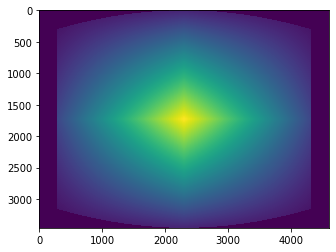

In [13]:
plt.imshow(blending_map)
plt.show()

In [14]:
cv2.imwrite('single_blending_map.jpg', np.clip(np.round(blending_map / blending_map.max() * 255), 0, 255).astype(np.uint8))

True

In [15]:
patch_size = 31
patch_size_half = patch_size//2
sift = SIFTDescriptor(patchSize = patch_size)

In [16]:
coordinate_for_imgs = []
features = []
response_map = []
for img in imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    R = harris_response(gray)
    R[blending_map<=0] = 0.0
    response_map.append(R)
    coord = detect_corner(R, num_peaks=1000, radius=20, threshold=10000000)
    new_coord = []
    new_feat  = []
    # compute sift feature
    for c in coord:
        cc = c[0]-patch_size_half
        rr = c[1]-patch_size_half
        patch = gray[rr:rr+patch_size, cc:cc+patch_size]
        if patch.shape != (patch_size, patch_size) or not np.any(patch):
            continue
        f = sift.describe(patch)
        if not np.any(f): # all zero
            continue
        new_feat.append(np.asarray(f))
        new_coord.append(np.asarray(c, dtype=np.int32))
    coordinate_for_imgs.append(np.asarray(new_coord))
    features.append(np.asarray(new_feat))

/home/peter0749/anaconda3/envs/panorama/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


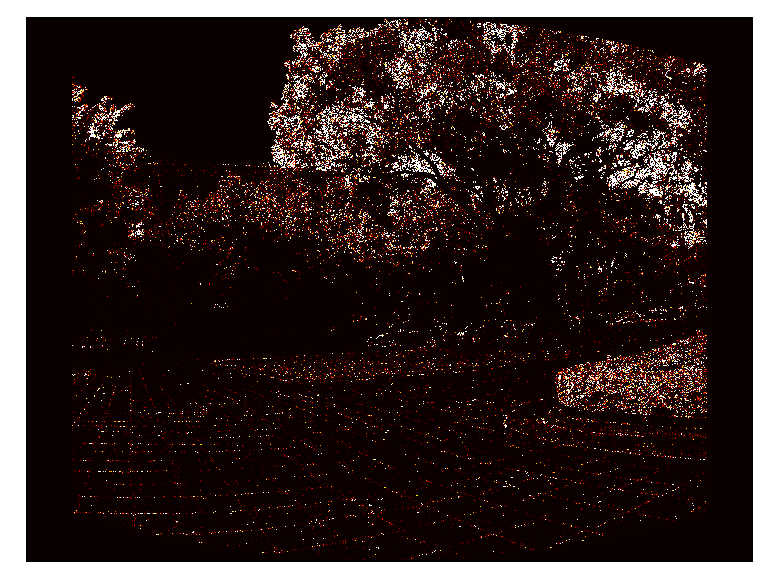

In [17]:
fig, ax = plt.subplots(1,1, dpi=180)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
response_map_clip = np.clip(response_map[0], 3000, 20000000)
ax.imshow(response_map_clip, cmap='hot')
fig.savefig('harris_response.png')
fig.show()

/home/peter0749/anaconda3/envs/panorama/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


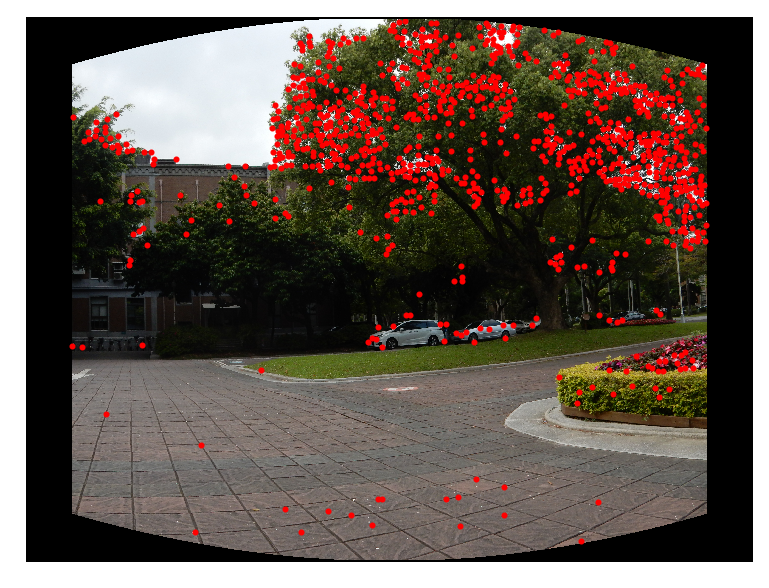

In [18]:
fig, ax = plt.subplots(1,1, dpi=180)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(imgs[0][...,::-1])
ax.scatter(coordinate_for_imgs[0][:,0], coordinate_for_imgs[0][:,1], s=2, color='red')
fig.savefig('harris_corner.png')
fig.show()

In [19]:
def estimate_affine_matrix(src, target):
    # src: (N, 2)
    # target: (N, 2)
    N = src.shape[0]
    A = np.zeros((N*2, 6), dtype=np.float32)
    A[::2,:2] = src
    A[::2,2]  = 1.0
    A[1::2,3:5] = src
    A[1::2,5] = 1.0
    A_pinv = np.linalg.pinv(A)
    b = target.ravel()
    x = np.matmul(A_pinv, b) # A.pinv * b
    return x.reshape(2,3)

In [20]:
def match(feat_a, feat_b, ratio=0.8):
    kd_tree = KDTree(feat_b)
    dist, idx = kd_tree.query(feat_a, k=2)
    final_idx = []
    for a_idx, (d, i) in enumerate(zip(dist, idx)):
        arg = np.argsort(d)
        dd = d[arg]
        ii = i[arg]
        if dd[0]>=dd[1]*ratio:
            continue
        final_idx.append((a_idx, ii[0]))
    return final_idx

In [21]:
def matchLR(feat_a, feat_b, ratio=0.8):
    matched_index_a2b = match(feat_a, feat_b, ratio=ratio)
    matched_index_b2a = match(feat_b, feat_a, ratio=ratio)
    matched_index = list(filter(lambda x: (x[1], x[0]) in matched_index_b2a, matched_index_a2b))
    return matched_index

In [22]:
def RANSAC(matched_pairs, coord_src, coord_tar, t=200000, threshold=5, stop_criteria=0.9):
    src_idx, tar_idx = zip(*matched_pairs)
    src_idx = np.asarray(src_idx, dtype=np.int32)
    tar_idx = np.asarray(tar_idx, dtype=np.int32)
    coord_src_matched = np.pad(coord_src[src_idx].T, ((0,1),(0,0)), mode='constant', constant_values=1.0) # (3, N)
    coord_tar_matched = coord_tar[tar_idx].T # (2, N)
    best_A = np.array([[1, 0, 0],[0, 1, 0]], dtype=np.float32)
    best = 0
    for _ in range(t):
        sampled_pair = np.random.choice(len(src_idx), 3 , replace=False)
        src_coord = coord_src[src_idx[sampled_pair]]
        tar_coord = coord_tar[tar_idx[sampled_pair]]
        A = estimate_affine_matrix(src_coord, tar_coord) # (2, 3)
        dist = np.linalg.norm(np.matmul(A, coord_src_matched) - coord_tar_matched, ord=2, axis=0)
        r_inliers = np.mean(dist<threshold)
        if r_inliers > best:
            best = r_inliers
            best_A = A
            if r_inliers > stop_criteria:
                break
    return best_A, best

In [23]:
def warpAffine(img, blending_map, A):
    h, w = img.shape[:2]
    end_points = np.array([[w-1,h-1,1], [w-1,0,1], [0,h-1,1]], dtype=np.float32).T # (3, N)
    warp_end_points = np.matmul(A, end_points) # (2, N) -- xy
    x_lim = max(int(np.ceil(np.max(warp_end_points[0])))+1, w)
    y_lim = max(int(np.ceil(np.max(warp_end_points[1])))+1, h)
    y_min = max(0, int(-np.min(warp_end_points[1])))
    A[1,2] = A[1,2] + y_min
    warp_blending_map = cv2.warpAffine(blending_map, A, (x_lim, y_lim+y_min), flags=cv2.INTER_CUBIC+cv2.WARP_FILL_OUTLIERS)
    warp_img = cv2.warpAffine(img, A, (x_lim, y_lim+y_min), flags=cv2.INTER_CUBIC+cv2.WARP_FILL_OUTLIERS)
    return warp_img, warp_blending_map, A, y_min

def blend_imgs(img_input, img_old, blending_map_input, blending_map_old):
    h_max = max(img_input.shape[0], img_old.shape[0])
    w_max = max(img_input.shape[1], img_old.shape[1])
    img_input = np.pad(img_input, ((0,h_max-img_input.shape[0]), (0,w_max-img_input.shape[1]), (0,0)), mode='constant', constant_values=0)
    img_old = np.pad(img_old, ((0,h_max-img_old.shape[0]), (0,w_max-img_old.shape[1]), (0,0)), mode='constant', constant_values=0)

    blending_map_input = np.pad(blending_map_input, ((0,h_max-blending_map_input.shape[0]), (0,w_max-blending_map_input.shape[1]), (0,0)), mode='constant', constant_values=0)
    blending_map_old = np.pad(blending_map_old, ((0,h_max-blending_map_old.shape[0]), (0,w_max-blending_map_old.shape[1]), (0,0)), mode='constant', constant_values=0)

    return img_input.astype(np.float32)*blending_map_input+img_old.astype(np.float32), blending_map_input+blending_map_old

In [24]:
blending_map_overall = np.copy(blending_map)[...,np.newaxis]
output = imgs[0] * blending_map_overall

A_prev = np.array([[1, 0, 0], [0, 1, 0]], dtype=np.float32)
est_x_skew = np.zeros(2, dtype=np.float32)
coord_prev = coordinate_for_imgs[0] # (N, 2)
feat_prev = features[0]
for i in range(1, len(features)):
    coord_prev_trans = np.matmul(A_prev, np.pad(coord_prev.T, ((0,1),(0,0)), mode='constant', constant_values=1.0)).T # (N, 2)
    matched_index = matchLR(features[i], feat_prev)
    A, inlier_frac = RANSAC(matched_index, coordinate_for_imgs[i], coord_prev_trans)
    est_x_skew = est_x_skew + A[0,:2]
    print(inlier_frac)
    warp_img, warp_blending_map, A_prev, y_shift = warpAffine(imgs[i], blending_map, A)
    warp_blending_map = warp_blending_map[...,np.newaxis]
    output = np.pad(output, ((y_shift,0),(0,0),(0,0)), mode='constant', constant_values=0)
    blending_map_overall = np.pad(blending_map_overall, ((y_shift,0),(0,0),(0,0)), mode='constant', constant_values=0)
    output, blending_map_overall = blend_imgs(warp_img, output, warp_blending_map, blending_map_overall)
    coord_prev = coordinate_for_imgs[i]
    feat_prev = features[i]
est_x_skew = est_x_skew / float(len(features)-1)
print("Estimated slope:", est_x_skew)

0.7362637362637363
0.7821782178217822
0.9083333333333333
0.903954802259887
0.9031007751937985
0.978328173374613
0.8714285714285714
0.8863636363636364
0.90625
0.9049773755656109
Estimated slope: [0.99442168 0.1566044 ]


In [25]:
def center_rotation_matrix(R, cx, cy):
    d = np.array([cx, cy], dtype=np.float32).reshape(2,1)
    trans = d + np.matmul(R, -d)
    return np.append(R, trans, axis=1)

In [26]:
x_unit = (est_x_skew / np.linalg.norm(est_x_skew, ord=2)).astype(np.float32)
y_unit = np.array([-x_unit[1], x_unit[0]], dtype=np.float32)
inverse_rotation = np.stack((x_unit, y_unit)).T
inverse_rotation = center_rotation_matrix(inverse_rotation, output.shape[1]*0.5, output.shape[0]*0.5)
inverse_rotation

array([[ 9.8782557e-01, -1.5556563e-01,  4.9804297e+02],
       [ 1.5556563e-01,  9.8782557e-01, -9.5201978e+02]], dtype=float32)

In [27]:
output = output / blending_map_overall
output[blending_map_overall[...,0]<=1e-6] = 0.0
output = np.clip(np.round(output), 0, 255).astype(np.uint8)

/home/peter0749/anaconda3/envs/panorama/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [28]:
cv2.imwrite('output.jpg', output)

True

In [29]:
blending_map_overall_uint8 = np.clip((blending_map_overall/blending_map_overall.max())*255, 0, 255).astype(np.uint8)
cv2.imwrite('blending_map.jpg', blending_map_overall_uint8)

True

In [30]:
fix_rotation = cv2.warpAffine(output, inverse_rotation, tuple(output.shape[:2][::-1]), flags=cv2.INTER_CUBIC+cv2.WARP_FILL_OUTLIERS)

In [31]:
cv2.imwrite('fix_rotation.jpg', fix_rotation)

True

In [32]:
gray = cv2.cvtColor(fix_rotation, cv2.COLOR_BGR2GRAY)
mask = cv2.threshold(cv2.medianBlur(gray,3), 1.0, 255.0, cv2.THRESH_BINARY)[1]

# findContours destroys input
contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]

# sort contours by largest first (if there are more than one)
contours = sorted(contours, key=lambda contour:len(contour), reverse=True)
x,y,w,h = cv2.boundingRect(contours[0])

cropped_img = fix_rotation[y:y+h,x:x+w]
cv2.imwrite('cropped_output.jpg', cropped_img)

True

In [33]:
def crop_panorama(img, min_width=300, min_height=300, tol=0.1):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = cv2.medianBlur(gray,5)<=0
    
    upper = 0
    while np.mean(mask[upper])>tol:
        upper += 1
    lower = mask.shape[0]-1
    while np.mean(mask[lower])>tol and lower-upper+1>min_height:
        lower -= 1
    left = 0
    while np.mean(mask[upper:lower+1,left])>tol:
        left += 1
    right = mask.shape[1]-1
    while np.mean(mask[upper:lower+1,right])>tol and right-left+1>min_width:
        right -=1
    return img[upper:lower+1,left:right+1], (upper, lower, left, right)

In [34]:
def apply_clahe(img, contrast_limit=0.25, grid_size=(8,8)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    clahe = cv2.createCLAHE(clipLimit=contrast_limit, tileGridSize=grid_size)
    eq_intensity = clahe.apply(hsv[...,2])
    hsv[...,2] = eq_intensity
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

In [35]:
cropped_rectangle, bound = crop_panorama(cropped_img)

In [36]:
cv2.imwrite('cropped.jpg', cropped_rectangle)
cv2.imwrite('cropped_eq.jpg', apply_clahe(cropped_rectangle))

True

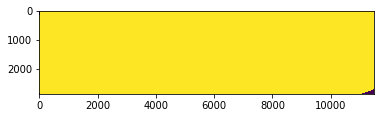

In [37]:
gray = cv2.cvtColor(cropped_rectangle, cv2.COLOR_BGR2GRAY)
bin_mask = np.where(cv2.threshold(cv2.medianBlur(gray,3), 1.0, 255.0, cv2.THRESH_BINARY)[1], 1, 0)
plt.imshow(bin_mask)
plt.show()

In [38]:
np.mean(bin_mask)

0.9985998145335546